In [1]:
import torchvision
import torchvision.transforms as transforms

# Download CIFAR-10 (without transforms)
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

In [2]:
import torch
from torch.utils.data import Dataset
import numpy as np
import cv2
from PIL import Image

class CIFAR10_HQ_vs_Degraded(Dataset):
    def __init__(self, base_dataset, degrade=False):
        self.base_dataset = base_dataset
        self.degrade = degrade
        self.final_transform = transforms.Compose([
            transforms.Resize((224, 224)),  # VGG expects 224x224
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
        ])

    def degrade_image(self, img):
        """Apply Gaussian blur + noise to degrade."""
        img_np = np.array(img)
        img_np = cv2.GaussianBlur(img_np, (5, 5), 2)  # Blur
        noise = np.random.normal(0, 25, img_np.shape).astype(np.uint8)  # Noise
        img_np = cv2.add(img_np, noise)
        return Image.fromarray(np.clip(img_np, 0, 255).astype('uint8'))

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        img, _ = self.base_dataset[idx]  # PIL image
        if self.degrade:
            img = self.degrade_image(img)
            label = 1  # Degraded
        else:
            label = 0  # High-quality
        img = self.final_transform(img)
        return img, label

In [3]:
# Create datasets
hq_dataset = CIFAR10_HQ_vs_Degraded(trainset, degrade=False)
degraded_dataset = CIFAR10_HQ_vs_Degraded(trainset, degrade=True)

# Combine and split into train/test
combined_dataset = torch.utils.data.ConcatDataset([hq_dataset, degraded_dataset])
train_size = int(0.8 * len(combined_dataset))
test_size = len(combined_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(combined_dataset, [train_size, test_size])

# DataLoaders
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

In [4]:
import torch
import torch.nn as nn
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Step 1: Load VGG16 without pretrained weights
vgg = models.vgg16(pretrained=False)  # Or weights=None in newer PyTorch

# Step 2: Load the manually downloaded weights

vgg.load_state_dict(torch.load(r"C:\Users\user\OneDrive - Ulster University\Desktop\MSc Pro Work\msProCode\vgg16-397923af.pth", map_location=device))

# Step 3: Freeze feature layers (optional)
for param in vgg.features.parameters():
    param.requires_grad = False

# Step 4: Modify classifier for binary classification
vgg.classifier[6] = nn.Linear(4096, 2)

# Step 5: Move model to device
vgg = vgg.to(device)

c:\Users\user\OneDrive - Ulster University\Desktop\MSc Pro Work\msProCode\env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user\OneDrive - Ulster University\Desktop\MSc Pro Work\msProCode\env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg.parameters(), lr=1e-4)

for epoch in range(5):
    vgg.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = vgg(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    accuracy = 100.0 * correct / total
    print(f"Epoch [{epoch+1}/5], Loss: {total_loss:.4f}, Accuracy: {accuracy:.2f}%")

Epoch [1/10], Loss: 2.0272, Accuracy: 99.95%
Epoch [2/10], Loss: 1.4175, Accuracy: 99.99%
Epoch [3/10], Loss: 1.8653, Accuracy: 100.00%
Epoch [4/10], Loss: 0.0000, Accuracy: 100.00%
Epoch [5/10], Loss: 0.3827, Accuracy: 100.00%


In [10]:
torch.save(vgg.state_dict(), "vgg16_cifar10_degradation.pth")

In [11]:
vgg.load_state_dict(torch.load("vgg16_cifar10_degradation.pth", map_location=device))
vgg.eval()
test_correct = 0
test_total = 0

# Test loop
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = vgg(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

test_accuracy = 100.0 * test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 100.00%


In [5]:
from sklearn.metrics import classification_report

all_preds_vgg = []
all_labels_vgg = []

vgg.eval()
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = vgg(images)
        _, preds = outputs.max(1)
        all_preds_vgg.extend(preds.cpu().numpy())
        all_labels_vgg.extend(labels.cpu().numpy())

print("VGG16 Classification Report:")
print(classification_report(all_labels_vgg, all_preds_vgg, target_names=['High Quality','Degraded']))


VGG16 Classification Report:
              precision    recall  f1-score   support

High Quality       0.66      0.80      0.72      9900
    Degraded       0.75      0.60      0.67     10100

    accuracy                           0.70     20000
   macro avg       0.70      0.70      0.69     20000
weighted avg       0.71      0.70      0.69     20000



Confusion Matrix

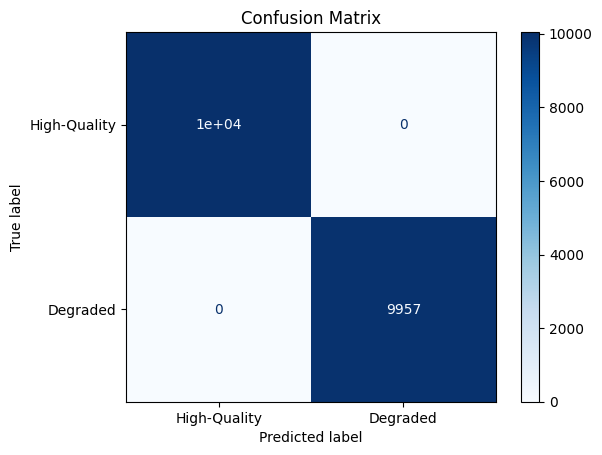

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

all_preds = []
all_labels = []

vgg.eval()
with torch.no_grad():
    for images, labels in testloader:
        images = images.to(device)
        outputs = vgg(images)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['High-Quality', 'Degraded'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


Classification Report (Precision, Recall, F1-score)

In [13]:
from sklearn.metrics import classification_report

print(classification_report(all_labels, all_preds, target_names=['High-Quality', 'Degraded']))

              precision    recall  f1-score   support

High-Quality       1.00      1.00      1.00     10043
    Degraded       1.00      1.00      1.00      9957

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000



Visualize Some Predictions (Correct vs Incorrect)

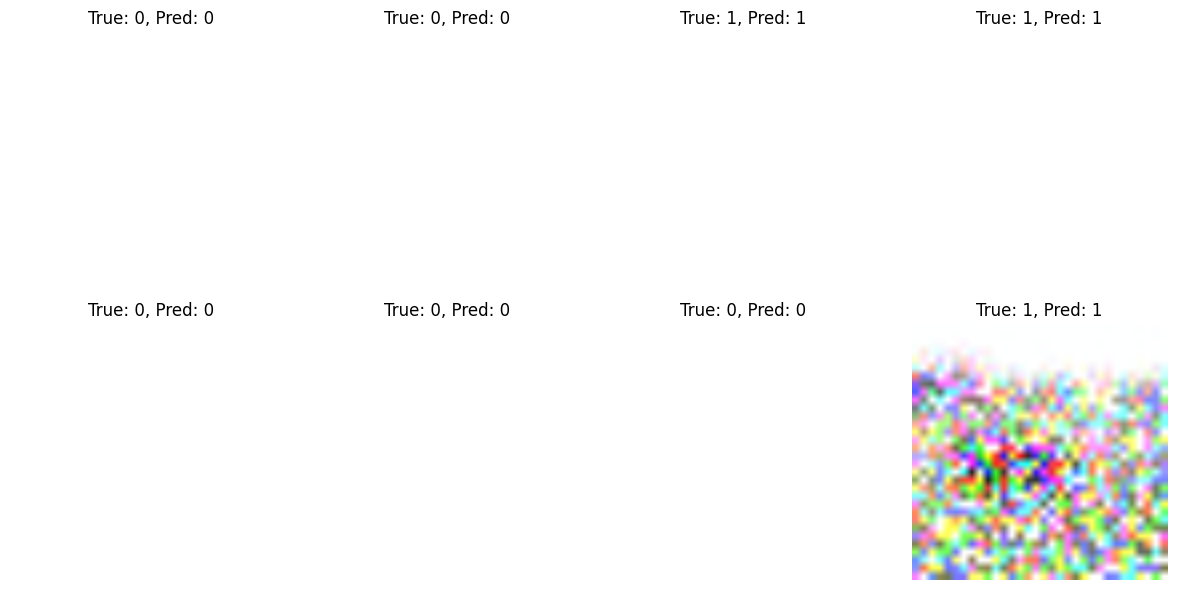

In [14]:
def imshow(img_tensor):
    img = img_tensor.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)

# Visualize 8 images with predictions
vgg.eval()
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.flatten()

with torch.no_grad():
    for i, (images, labels) in enumerate(testloader):
        images, labels = images.to(device), labels.to(device)
        outputs = vgg(images)
        _, preds = outputs.max(1)
        for j in range(8):
            imshow(images[j])
            axes[j].set_title(f"True: {labels[j].item()}, Pred: {preds[j].item()}")
            axes[j].axis('off')
        break  # Just one batch
plt.tight_layout()
plt.show()


Visualizing Feature Embeddings

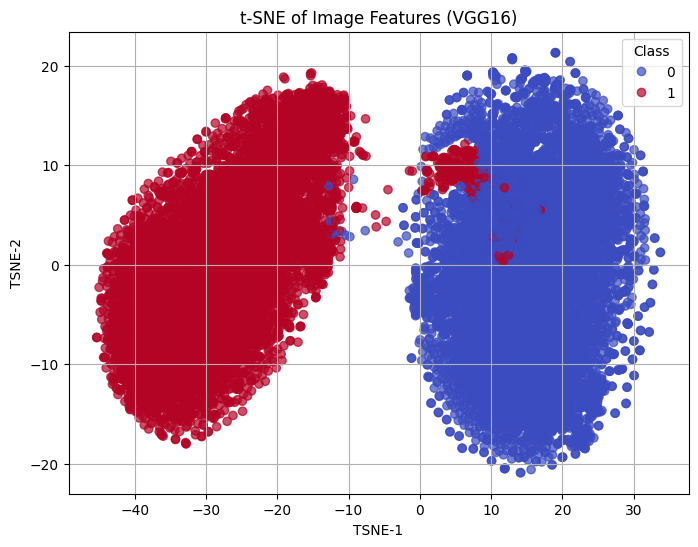

In [15]:
from sklearn.manifold import TSNE
import numpy as np

features = []
labels_list = []

vgg.eval()
with torch.no_grad():
    for images, labels in testloader:
        images = images.to(device)
        x = vgg.features(images)
        x = x.view(x.size(0), -1)
        features.append(x.cpu().numpy())
        labels_list.extend(labels.numpy())
features = np.concatenate(features, axis=0)

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
features_2d = tsne.fit_transform(features)

# Plot
plt.figure(figsize=(8,6))
scatter = plt.scatter(features_2d[:,0], features_2d[:,1], c=labels_list, cmap='coolwarm', alpha=0.7)
plt.title('t-SNE of Image Features (VGG16)')
plt.legend(*scatter.legend_elements(), title="Class")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.grid(True)
plt.show()


Loss and Accuracy Curves